# Modeling a roulette wheel in vanilla Python

The first thing to do is model the possible results.  The places where the ball can settle are called "pockets."  American roulette has two green pockets call "0" and "00."  I'm going to lazily label the double zero pocket as -1 for now.  The rest of the pockets are evenly (though irregularly) divided between red and black.

In [125]:
POCKETS =(
    (-1, 'green'),
    (0, 'green'),
    (1, 'red'),
    (2, 'black'),
    (3, 'red'),
    (4, 'black'),
    (5, 'red'),
    (6, 'black'),
    (7, 'red'),
    (8, 'black'),
    (9, 'red'),
    (10, 'black'),
    (11, 'black'),
    (12, 'red'),
    (13, 'black'),
    (14, 'red'),
    (15, 'black'),
    (16, 'red'),
    (17, 'black'),
    (18, 'red'),
    (19, 'red'),
    (20, 'black'),
    (21, 'red'),
    (22, 'black'),
    (23, 'red'),
    (24, 'black'),
    (25, 'red'),
    (26, 'black'),
    (27, 'red'),
    (28, 'black'),
    (29, 'black'),
    (30, 'red'),
    (31, 'black'),
    (32, 'red'),
    (33, 'black'),
    (34, 'red'),
    (35, 'black'),
    (36, 'red'))

We'll use the `choice()` function from Python's standard library to simulate the ball landing in a random pocket each round.

In [126]:
from random import choice

Here's an example of calling `random.choice()` with the `POCKETS` we defined above.

In [127]:
display(choice(POCKETS))

(8, 'black')

Let's make sure that the results of calling `choice(POCKETS)` repeatedly looks like we'd expect.  We expect each possible result to be equally likely.  We can add up the frequencies of lots of objects using `collections.Counter()`

In [128]:
from collections import Counter

In [129]:
million_spins = tuple(choice(POCKETS) for _ in range(1_000_000))
million_spin_frequencies = sorted(Counter(million_spins).most_common())
print("Pocket\tFrequency")
for pocket in million_spin_frequencies:
    print(f"{pocket[0][0]}\t{pocket[1]:,g}")

Pocket	Frequency
-1	26,368
0	26,445
1	26,316
2	26,329
3	26,246
4	26,316
5	26,270
6	26,392
7	26,145
8	26,511
9	25,996
10	26,214
11	26,507
12	26,023
13	26,277
14	26,353
15	26,455
16	25,759
17	26,119
18	26,555
19	26,377
20	26,304
21	26,496
22	26,508
23	26,429
24	26,339
25	26,457
26	26,422
27	26,519
28	26,280
29	26,406
30	26,284
31	26,339
32	26,379
33	26,122
34	26,233
35	26,227
36	26,283


The table's a bit long, perhaps a graph?

In [130]:
import matplotlib.pyplot as plt

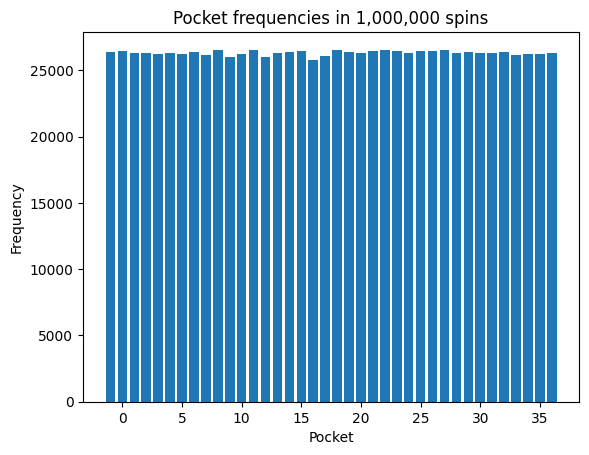

In [131]:
fig, ax = plt.subplots()
ax.bar([pocket[0][0] for pocket in million_spin_frequencies], [pocket[1] for pocket in million_spin_frequencies])
ax.set_title("Pocket frequencies in 1,000,000 spins")
ax.set_xlabel("Pocket")
ax.set_ylabel("Frequency")
plt.show()

That seems relatively uniform to me.

The next step is to model some bets, meaning a funciton that takes the round's winning pocket and the player's bet and returns how their balance should change.  The strategies that we want to test focus on "outside" bets, specifically the ones with the most even odds such as even, odd, red, or black, so I will start with those.

In [132]:
def bet_even(pocket, bet):
    pocket_number, pocket_color = pocket
    if pocket_number > 0 and pocket_number % 2 == 0:
        return bet
    else:
        return -bet


In [133]:
def bet_odd(pocket, bet):
    pocket_number, pocket_color = pocket
    if pocket_number > 0 and pocket_number % 2 == 1:
        return bet
    else:
        return -bet

In [134]:
def bet_red(pocket, bet):
    pocket_number, pocket_color = pocket
    if pocket_color == "red":
        return bet
    else:
        return -bet

In [135]:
def bet_black(pocket, bet):
    pocket_number, pocket_color = pocket
    if pocket_color == "black": 
        return bet
    else: 
        return -bet

Let's test these betting strategies with a sample bet of $1 just to see if they behave the way we expect.

Test Even:

In [136]:
for round in range(10):
    winning_pocket = choice(POCKETS)
    result = bet_even(winning_pocket, 1)
    print(f"{winning_pocket} {result}")

(15, 'black') -1
(22, 'black') 1
(34, 'red') 1
(20, 'black') 1
(20, 'black') 1
(28, 'black') 1
(34, 'red') 1
(15, 'black') -1
(29, 'black') -1
(0, 'green') -1


Test odd

In [137]:
for round in range(10):
    winning_pocket = choice(POCKETS)
    result = bet_odd(winning_pocket, 1)
    print(f"{winning_pocket} {result}")

(7, 'red') 1
(22, 'black') -1
(10, 'black') -1
(30, 'red') -1
(23, 'red') 1
(17, 'black') 1
(26, 'black') -1
(3, 'red') 1
(20, 'black') -1
(14, 'red') -1


Test Red

In [138]:
for round in range(10):
    winning_pocket = choice(POCKETS)
    result = bet_red(winning_pocket, 1)
    print(f"{winning_pocket} {result}")

(16, 'red') 1
(0, 'green') -1
(11, 'black') -1
(33, 'black') -1
(31, 'black') -1
(18, 'red') 1
(34, 'red') 1
(32, 'red') 1
(27, 'red') 1
(10, 'black') -1


Test black

In [139]:
for round in range(10):
    winning_pocket = choice(POCKETS)
    result = bet_black(winning_pocket, 1)
    print(f"{winning_pocket} {result}")

(0, 'green') -1
(3, 'red') -1
(5, 'red') -1
(-1, 'green') -1
(22, 'black') 1
(36, 'red') -1
(5, 'red') -1
(1, 'red') -1
(8, 'black') 1
(11, 'black') 1


The final step is to model different betting strategies and graph the results.